## CS109b Final Project - Group 24  
### Milestone 3

Tyler Finkelstein  
James Fallon  
Aaron Myran  
Ihsan Patel 

# Libraries and Helper Functions

In [1]:
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation

In [46]:
def model_evaluation(X, y, model, label):
    predictions = model.predict(X)
    #calculate accuracy
    accuracy = accuracy_score(y, predictions)
    print('{0} Accuracy: {1:.4f}'.format(label, accuracy))
    #calculate precision
    precision_weighted = precision_score(y, predictions, labels=sorted(y.unique()), average='weighted')
    print('{0} Precision - Weighted: {1:.4f}'.format(label, precision_weighted))
    #calculate recall
    recall_weighted = recall_score(y, predictions, labels=sorted(y.unique()), average='weighted')
    print('{0} Recall - Weighted: {1:.4f}'.format(label, recall_weighted))
    #calculate f1
    f1_weighted = f1_score(y, predictions, labels=sorted(y.unique()), average='weighted')
    print('{0} F1 - Weighted: {1:.4f}'.format(label, f1_weighted))    
    cm = confusion_matrix(y, predictions)
    df_cm = np.transpose( np.transpose(cm) / cm.astype(np.float).sum(axis=1) )
    df_cm = pd.DataFrame(df_cm, index = sorted(y.unique()), columns = sorted(y.unique()))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
def plot_roc(model_list, model_names, y):
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    for i, model in enumerate(model_list):
        col_names = sorted(y.unique())
        predictions = pd.DataFrame(model[0].predict_proba(model[1]), columns = col_names)
        predictions.to_csv(model_names[i] + '_probabilities.csv', index = False)
        actual = pd.DataFrame({})
        for column in col_names:
            actual[column] = y.apply(lambda y: y == column) 
        fpr["micro - " + model_names[i]], tpr["micro - " + model_names[i]], _ = roc_curve(actual.as_matrix().ravel(), predictions.as_matrix().ravel())
        roc_auc["micro - " + model_names[i]] = auc(fpr["micro - " + model_names[i]], tpr["micro - " + model_names[i]])
    plt.figure(figsize=(10,10))
    colors = 'bgr'
    for i, color in zip(fpr.keys(), colors):
        plt.plot(fpr[i], tpr[i], color=color, linestyle=':',
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Genre')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def get_feature_importance(model, X_train):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    feature_importance = [feature_importance[i] for i in indices]
    predictors = X_train.columns
    predictors = [predictors[i] for i in indices]
    predictors_index = range(1, len(predictors) + 1)
    num_features = X_train.shape[1]
    #num_features = len(predictors) if num_features is None else num_features
    plt.figure(figsize=(20,20))
    plt.bar(predictors_index[:num_features], feature_importance[:num_features], align = 'center')
    plt.xticks(predictors_index[:num_features], predictors[:num_features], rotation = 'vertical')
    plt.show()

# Load and Clean Data

In [5]:
# load and clean data
train_df = pd.read_csv('../Milestone_4/ihsaan_files/train_w_poster_updated_genres.csv')
test_df = pd.read_csv('../Milestone_4/ihsaan_files/test_w_poster_updated_genres.csv')

In [6]:
print(train_df.shape)
print(test_df.shape)

(8183, 78)
(3495, 78)


In [7]:
X_train = train_df.drop(['genre', 'id', 'poster_path', 'pp'], axis = 1)
y_train = train_df['genre']
X_test = test_df.drop(['genre', 'id', 'poster_path', 'pp'], axis = 1)
y_test = test_df['genre']

# Random Forest

We implemented a Random Forest Classifier on our data, which essentially grows decision trees while randomizing the subset of predictors used to grow those trees. The model than takes the mode of the outcomes of all the trees and records that class as the model's prediction.

With the sklearn package, we tuned a random forest classifier using grid search with 5-fold cross-validation on the following parameters:
* `n_estimators`: the number of trees grown in the model. We did not vary this and set it at 500 under the assumption that more trees would improve model accuracy (with the trade-off being the amount of time taken to run the model)
* `max_features`: the number of features in the subset used to train the tree. The more features selected, the more likely the model is to overfit. We used the 3 options provided by the sklearn package - auto, sqrt, and log2.
* `min_samples_leaf`: the numeber of samples in a particular branch at which the tree stops growing. The lower the number, the more likely the tree is to overfit. We used 1, 10, and 100.
class_weight: the sklearn package offers built-in options to deal with class imbalance which is an issue for us, so we tuned the model on 3 parameters - None, balanced, and balanced_subsample.
* `max_depth`: the depth to which individual decision trees are grown, with higher values increasing the chance of overfitting. We used 10, 100, and None for this parameter.

We chose the f1 score as the evaluation metric to optimize for given the large number and unbalanced nature of the classes.

In [11]:
RF_PARAMETERS = {'n_estimators': [500],'max_features' : ['auto', 'sqrt', 'log2'], 'min_samples_leaf' : [1, 10, 100],
'random_state': [42], 'class_weight' : [None, 'balanced', 'balanced_subsample'], 'max_depth': [10, 100, None]}

## Use All Features

### Tune Model

In [12]:
rf_model = RandomForestClassifier()
rf_model_cv = GridSearchCV(rf_model, RF_PARAMETERS, scoring = "f1", cv = 5, verbose = 10)
rf_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.410435 -   6.0s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    6.0s


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.394087 -   5.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.422253 -   5.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.415380 -   5.1s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:   21.8s


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.415328 -   6.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.404288 -   4.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.385540 -   4.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:   37.5s


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.404341 -   5.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.406559 -   5.6s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.408548 -   5.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.305950 -   3.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:  1.0min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.305845 -   3.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.331433 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.318859 -   3.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.410435 -   4.6s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:  1.4min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.422253 -   4.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.415380 -   4.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.415328 -   4.6s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.404288 -   4.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[

[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:  1.9min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.408548 -   4.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.305950 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.299989 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.305845 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_we

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  2.3min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.377786 -   3.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.386768 -   3.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.395828 -   4.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.401597 -   4.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  2.9min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.273936 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.267502 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.279549 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.282268 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_w

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  3.7min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.473640 -   8.1s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.446533 -   5.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.421680 -   5.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.447038 -   5.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_we

[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:  4.6min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.472310 -   8.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.445067 -   9.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.485324 -   8.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.476916 -   8.1s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=No

[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:  5.8min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.301412 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.304681 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.329545 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.317821 -   3.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=100, c

[Parallel(n_jobs=1)]: Done  84 tasks       | elapsed:  6.9min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.432288 -   4.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.275000 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.266216 -   2.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.280216 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, 

[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed:  8.1min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.447038 -   5.1s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.444635 -   5.1s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.435215 -   5.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.311658 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=No

[Parallel(n_jobs=1)]: Done 112 tasks       | elapsed:  9.4min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.447038 -   5.1s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.444635 -   5.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.435215 -   5.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.311658 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=No

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed: 10.6min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.426998 -   4.1s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.429284 -   4.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.432288 -   4.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.275000 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=No

[Parallel(n_jobs=1)]: Done 144 tasks       | elapsed: 11.7min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.465922 -   4.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.383710 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.388876 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.405453 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed: 12.8min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.388876 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.405453 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.392629 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.416173 -   3.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=l

[Parallel(n_jobs=1)]: Done 180 tasks       | elapsed: 13.9min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.452157 -   8.0s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.443829 -   8.0s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.469526 -   8.0s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.466241 -   7.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, ma

[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 15.9min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.456746 -   8.6s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.451291 -   5.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.446553 -   5.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.471358 -   5.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=s

[Parallel(n_jobs=1)]: Done 220 tasks       | elapsed: 17.8min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.382910 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.386929 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.401326 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.392146 -   3.0s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_f

[Parallel(n_jobs=1)]: Done 241 tasks       | elapsed: 19.7min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.443829 -   9.0s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.469526 -   8.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.466241 -   8.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.456746 -   8.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=

[Parallel(n_jobs=1)]: Done 264 tasks       | elapsed: 21.8min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.483558 -   4.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.382910 -   2.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.386929 -   2.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.401326 -   2.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42,

[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed: 23.3min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.467817 -   4.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.475101 -   4.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.480949 -   4.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.431137 -   4.5s
[CV] min_samples

[Parallel(n_jobs=1)]: Done 312 tasks       | elapsed: 25.0min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.402582 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.392260 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.413689 -   3.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced_subsample, score=0.456026 -   8.0s
[CV] m

[Parallel(n_jobs=1)]: Done 337 tasks       | elapsed: 27.4min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.470183 -   5.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.471694 -   5.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.487150 -   5.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.386409 -   3.7s
[C

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed: 29.8min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.459362 -   8.0s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.459052 -   5.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.445971 -   5.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.470183 -   5.4

[Parallel(n_jobs=1)]: Done 391 tasks       | elapsed: 32.2min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.436117 -   6.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.458402 -   6.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.455691 -   6.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.458206 -   6.9s
[CV]

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 33.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 10, 100], 'n_estimators': [500], 'random_state': [42], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 100, None], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=10)

### Evaluate Model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Train Accuracy: 1.0000
Train Precision - Weighted: 1.0000
Train Recall - Weighted: 1.0000
Train F1 - Weighted: 1.0000


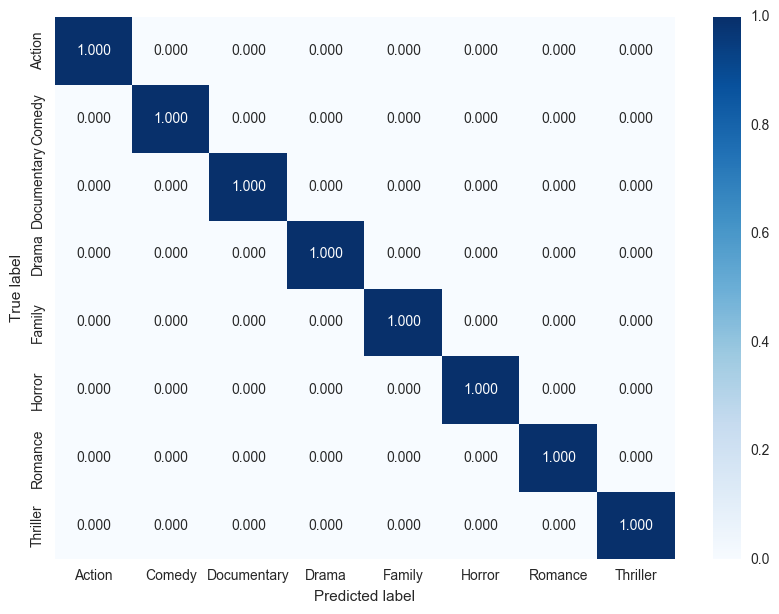

Test Accuracy: 0.5104
Test Precision - Weighted: 0.5139
Test Recall - Weighted: 0.5104
Test F1 - Weighted: 0.4764


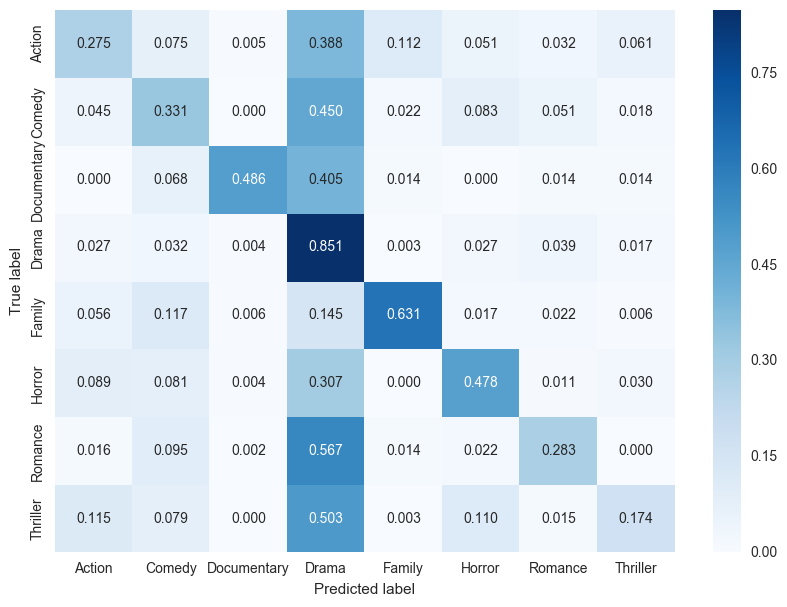

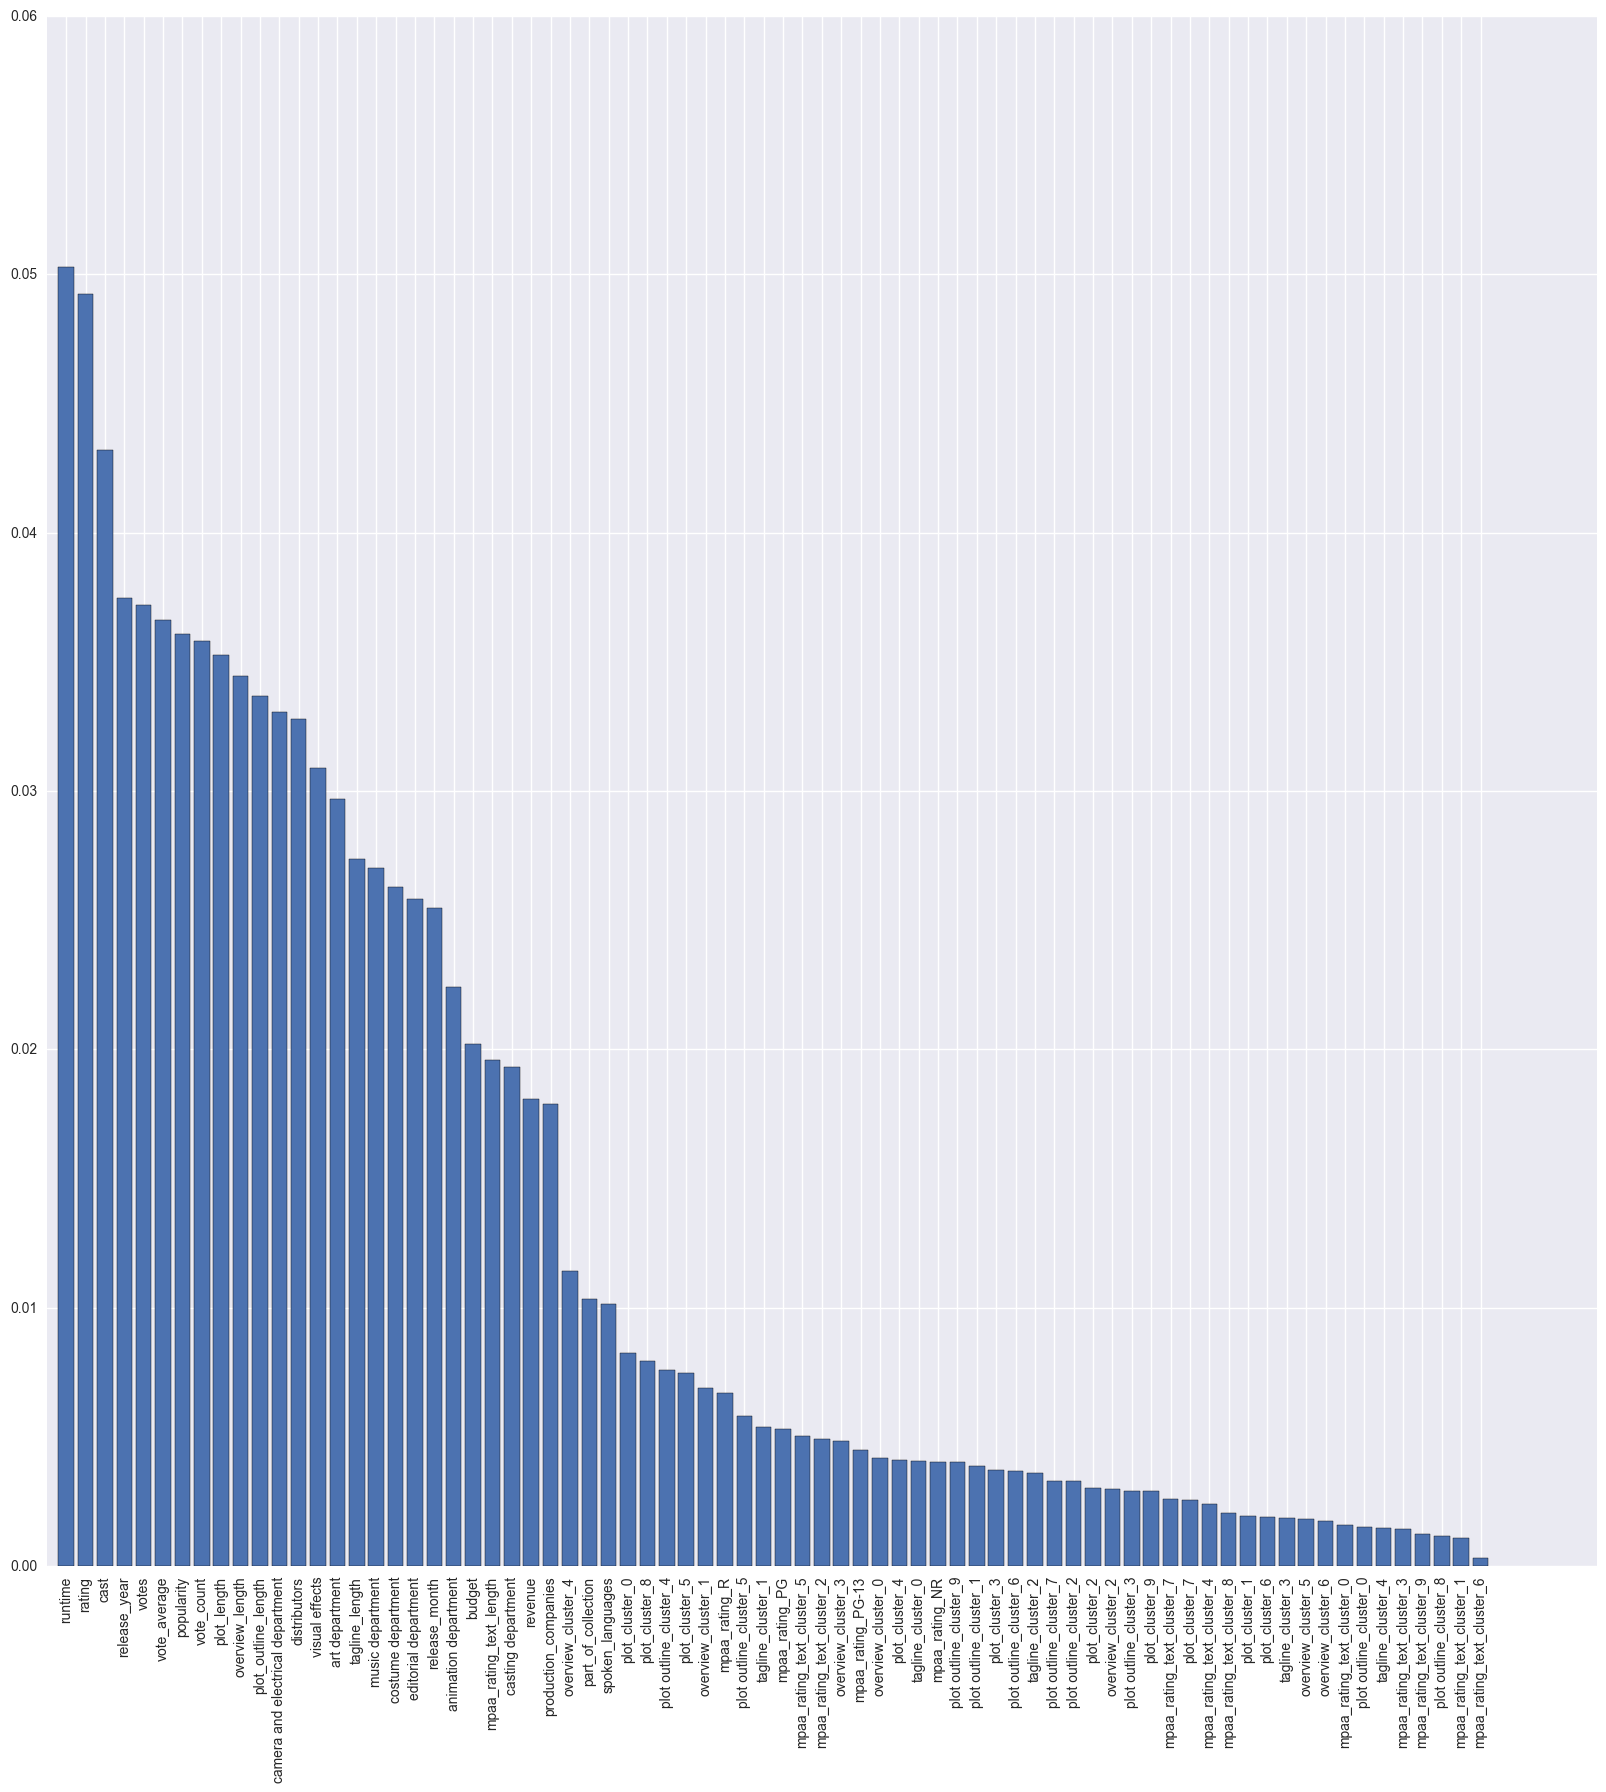

In [48]:
print(rf_model_cv.best_estimator_)
rf_model_chosen = rf_model_cv.best_estimator_
model_evaluation(X_train, y_train, rf_model_chosen, 'Train')
model_evaluation(X_test, y_test, rf_model_chosen, 'Test')
get_feature_importance(rf_model_chosen, X_train)

The model performed significantly better than a random classifier as the above performance metrics show.

We visualized the model's performance using both confusion matrices and ROC curves. The confusion matrix for the test set showed that the model performed well on genres like Documentary, Drama, and Family, but more poorly on genres like Thriller, Action, and Romance. More problematic was that the model's performance on the training set yielded 100% accuracy, indicating potential overfitting during training. However, when we ran the model using smaller amounts of predictors (filtering based on feature importance), all of the performance metrics mentioned above declined as well (see below). This bears further investigation.

## Exclude Rating / Clustering

In [14]:
columns_to_include = [column for column in X_train.columns if 'cluster' not in column and 'mpaa_rating' not in column]
X_train_1 = X_train[columns_to_include]
X_test_1 = X_test[columns_to_include]

### Tune Model

In [15]:
rf_model = RandomForestClassifier()
rf_model_cv_1 = GridSearchCV(rf_model, RF_PARAMETERS, scoring = "f1", cv = 5, verbose = 10)
rf_model_cv_1.fit(X_train_1, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.365147 -   5.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    5.5s


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.366854 -   5.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.365201 -   5.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.394347 -   5.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:   21.7s


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.380209 -   5.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.365286 -   4.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.361605 -   4.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:   37.0s


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.359669 -   4.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.383289 -   4.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.377274 -   5.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.305444 -   3.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:   59.0s


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.303422 -   3.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.310064 -   3.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.301053 -   3.6s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.365147 -   5.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:  1.3min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.365201 -   5.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.394347 -   5.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.380209 -   5.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.365286 -   4.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[

[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:  1.9min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.377274 -   5.0s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.305444 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.293019 -   3.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.303422 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_we

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  2.4min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.361513 -   4.6s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.356476 -   4.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.384842 -   4.6s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.370272 -   4.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  3.1min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.302990 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.286040 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.299648 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.300178 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_w

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  3.9min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.418995 -   8.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.392548 -   5.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.375231 -   5.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.365459 -   5.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_we

[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:  4.8min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.419303 -   8.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.407692 -   8.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.400672 -   8.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.396453 -   8.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=No

[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:  6.0min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.292455 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.302772 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.311151 -   3.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.300241 -   3.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=100, c

[Parallel(n_jobs=1)]: Done  84 tasks       | elapsed:  7.2min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.387946 -   5.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.302675 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.286040 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.299084 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, 

[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed:  8.4min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.365459 -   5.6s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.390868 -   5.6s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.392299 -   5.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.305800 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=No

[Parallel(n_jobs=1)]: Done 112 tasks       | elapsed:  9.8min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.365459 -   5.6s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.390868 -   5.6s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.392299 -   5.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.305800 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=No

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed: 11.2min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.364631 -   4.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.387854 -   4.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.387946 -   4.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.302675 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=No

[Parallel(n_jobs=1)]: Done 144 tasks       | elapsed: 12.5min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.418211 -   4.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.334026 -   3.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.351837 -   3.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.358175 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed: 13.7min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.351837 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.358175 -   3.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.368529 -   3.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.387707 -   3.6s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=l

[Parallel(n_jobs=1)]: Done 180 tasks       | elapsed: 15.0min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.405821 -   8.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.402783 -   8.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.393294 -   8.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.392758 -   8.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, ma

[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 17.0min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.413922 -   8.5s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.407657 -   5.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.401616 -   5.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.413376 -   5.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=s

[Parallel(n_jobs=1)]: Done 220 tasks       | elapsed: 19.0min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.329530 -   3.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.354217 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.360303 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.365852 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_f

[Parallel(n_jobs=1)]: Done 241 tasks       | elapsed: 20.9min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.402783 -   8.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.393294 -   8.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.392758 -   8.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.413922 -   8.5s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=

[Parallel(n_jobs=1)]: Done 264 tasks       | elapsed: 23.2min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.446841 -   5.0s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.329530 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.354217 -   3.2s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.360303 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42,

[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed: 25.0min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.405512 -   5.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.422826 -   5.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.431034 -   5.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.397324 -   5.3s
[CV] min_samples

[Parallel(n_jobs=1)]: Done 312 tasks       | elapsed: 27.0min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.355511 -   3.7s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.362634 -   3.6s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.380352 -   3.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced_subsample, score=0.405742 -   8.8s
[CV] m

[Parallel(n_jobs=1)]: Done 337 tasks       | elapsed: 29.7min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.418045 -   6.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.422599 -   6.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.441460 -   6.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.337811 -   4.0s
[C

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed: 32.4min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.411799 -   9.0s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.413144 -   6.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.401163 -   6.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.418045 -   6.5

[Parallel(n_jobs=1)]: Done 391 tasks       | elapsed: 35.2min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.391310 -   7.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.389620 -   7.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.395268 -   7.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.399972 -   7.9s
[CV]

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 36.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 10, 100], 'n_estimators': [500], 'random_state': [42], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 100, None], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=10)

### Evaluate Model

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Train Accuracy: 0.7330
Train Precision - Weighted: 0.7652
Train Recall - Weighted: 0.7330
Train F1 - Weighted: 0.7364


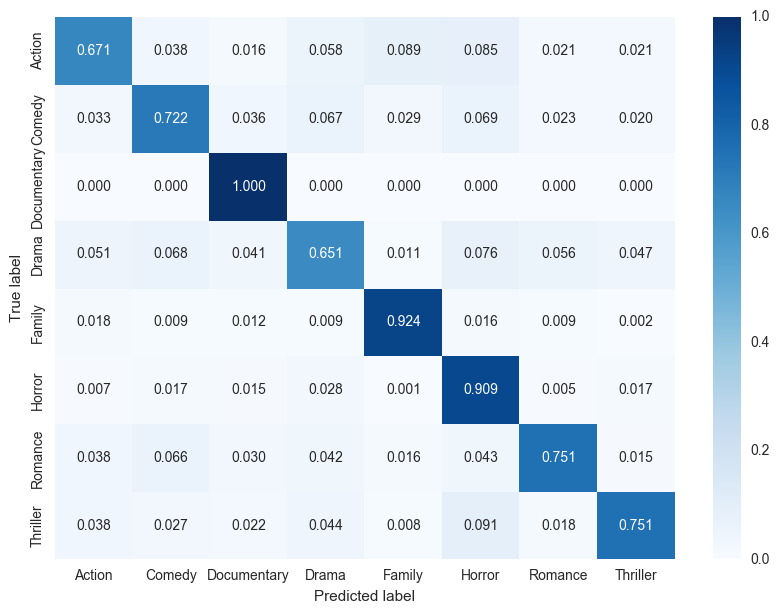

Test Accuracy: 0.4160
Test Precision - Weighted: 0.4369
Test Recall - Weighted: 0.4160
Test F1 - Weighted: 0.4158


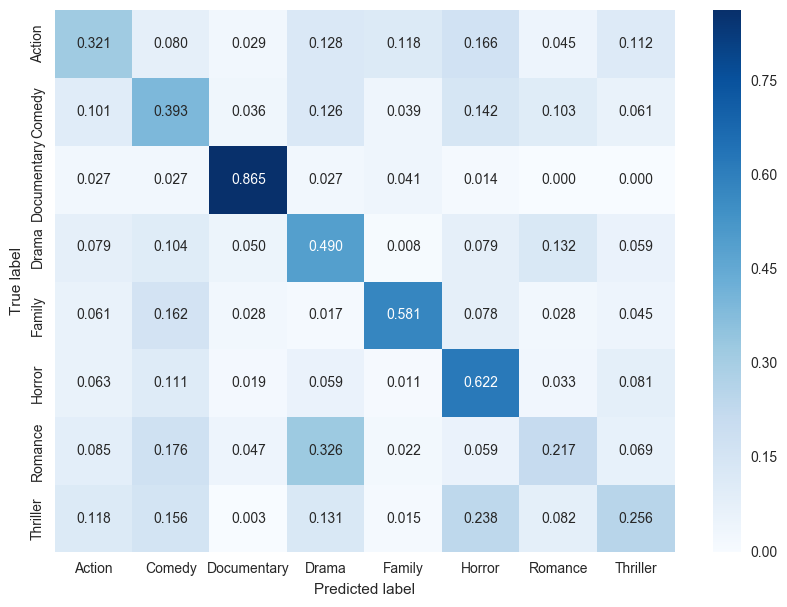

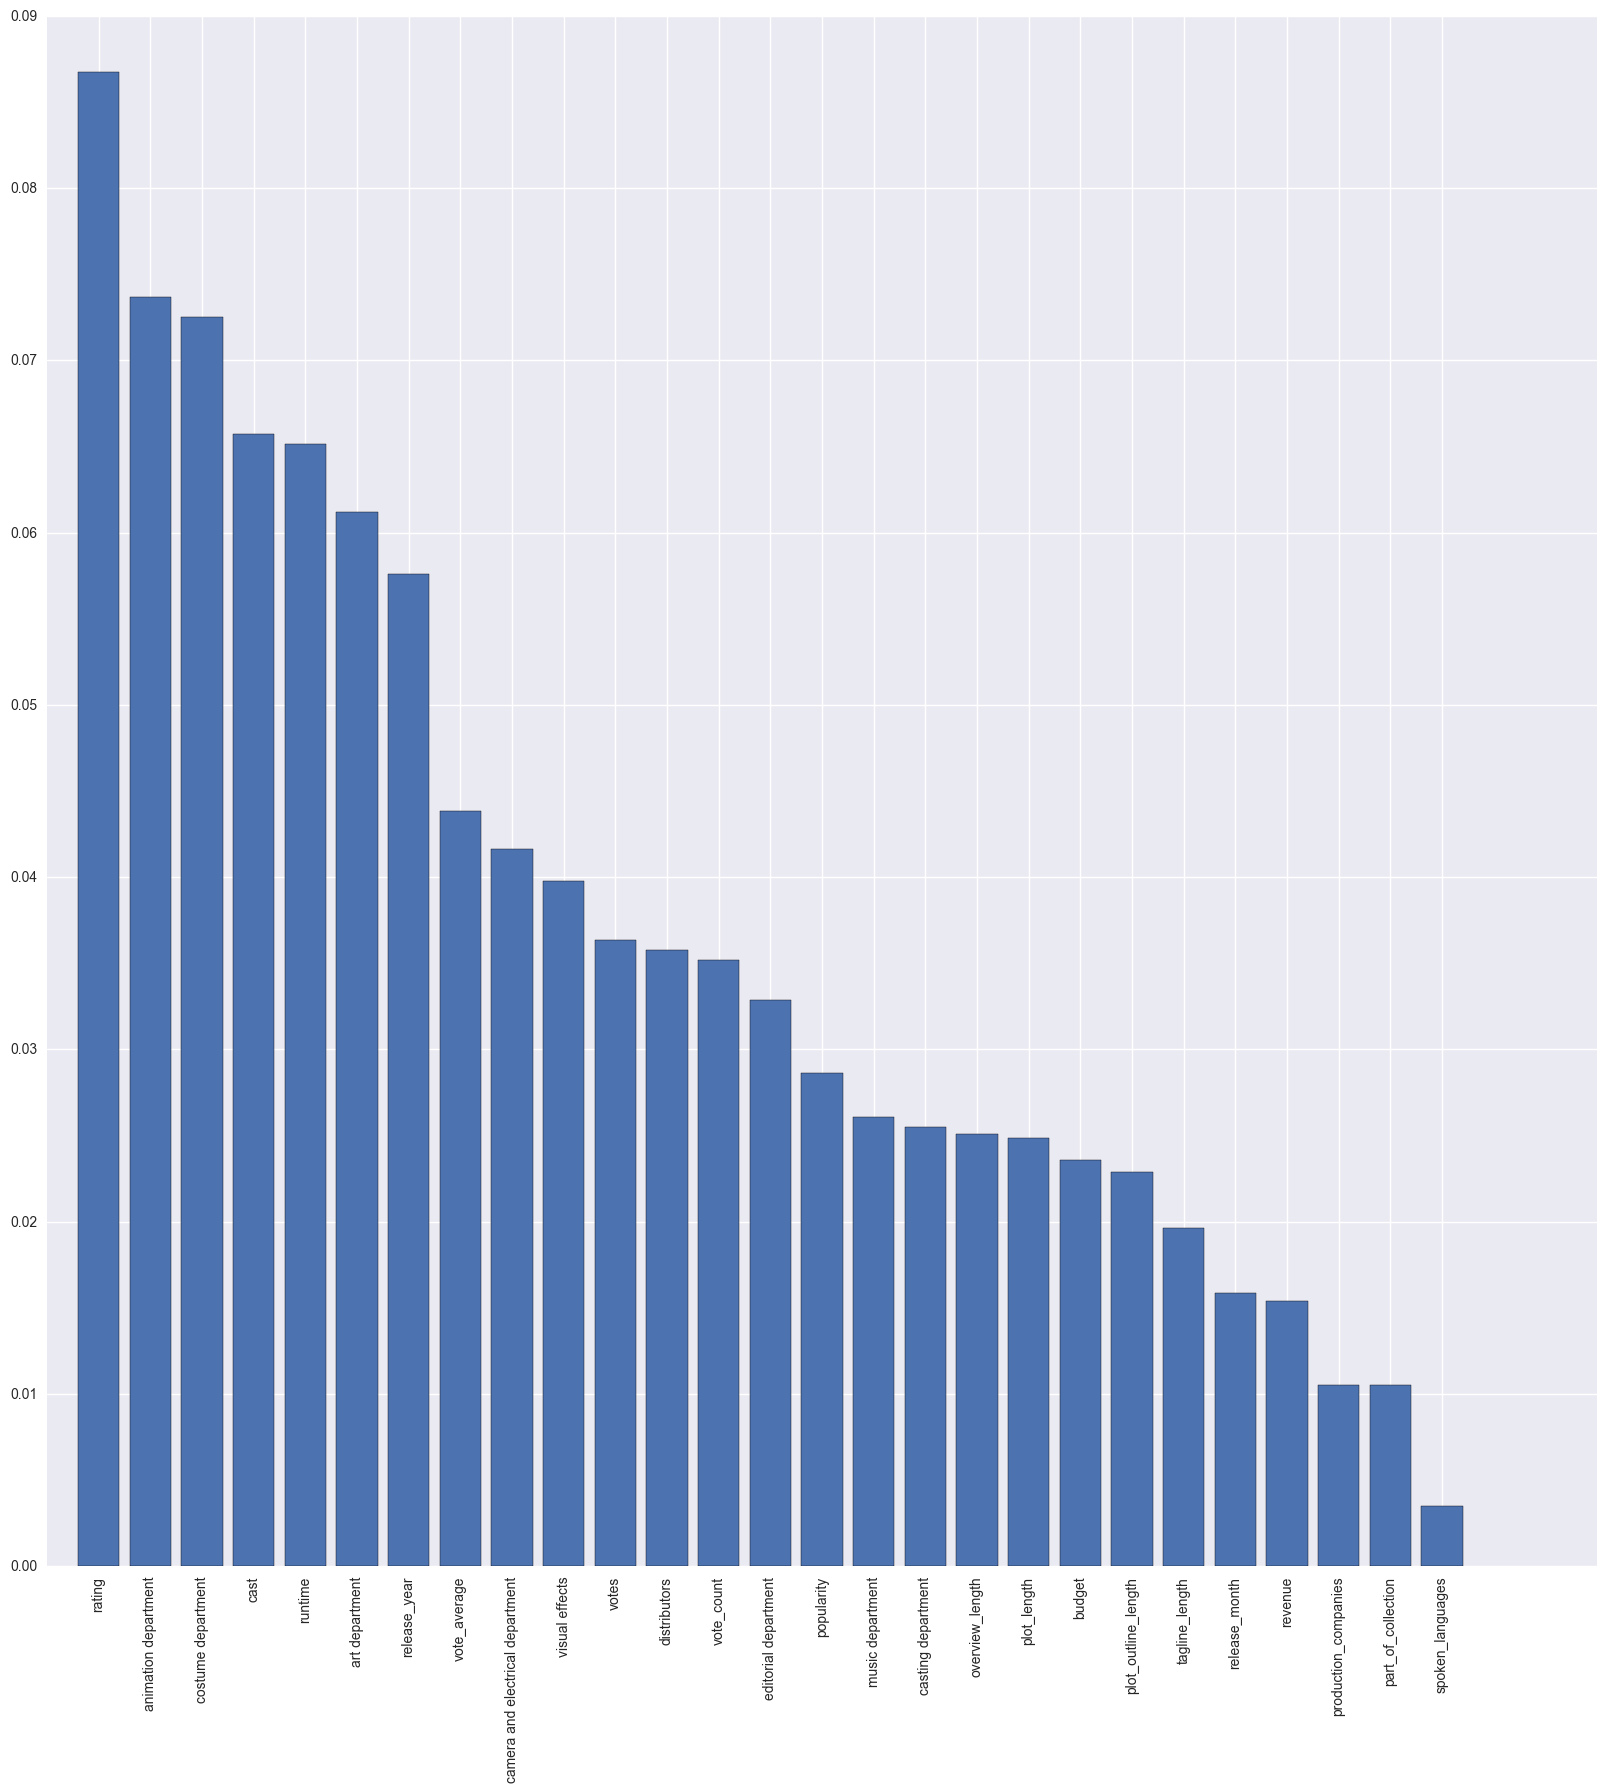

In [50]:
print(rf_model_cv_1.best_estimator_)
rf_model_chosen_1 = rf_model_cv_1.best_estimator_
model_evaluation(X_train_1, y_train, rf_model_chosen_1, 'Train')
model_evaluation(X_test_1, y_test, rf_model_chosen_1, 'Test')
get_feature_importance(rf_model_chosen_1, X_train_1)

## Top 10 Feature Importance

In [17]:
columns_to_include =['rating', 'runtime', 'cast', 'release_year', 'votes', 'vote_average', 'art department', 'popularity',
                'camera and electrical department', 'costume department']
X_train_2 = X_train[columns_to_include]
X_test_2 = X_test[columns_to_include]

### Tune

In [18]:
rf_model = RandomForestClassifier()
rf_model_cv_2 = GridSearchCV(rf_model, RF_PARAMETERS, scoring = "f1", cv = 5, verbose = 10)
rf_model_cv_2.fit(X_train_2, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.364608 -   4.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    4.4s


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.343376 -   4.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.361357 -   4.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.360295 -   4.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:   17.5s


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.365786 -   4.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.362230 -   4.0s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.340113 -   3.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 


[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:   29.8s


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.356559 -   4.0s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.366530 -   3.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.364745 -   3.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.282590 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:   47.2s


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.280543 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.288222 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=None, score=0.272996 -   2.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.364608 -   4.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:  1.1min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.361357 -   4.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.360295 -   4.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.365786 -   4.2s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.362230 -   3.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[

[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:  1.5min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.364745 -   3.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.282590 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.262901 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=None, score=0.280543 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_we

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  1.9min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.343376 -   4.3s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.361357 -   4.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.360295 -   4.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.365786 -   4.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  2.5min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.282590 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.262901 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.280543 -   3.0s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=None, score=0.288222 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_w

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  3.2min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.382649 -   6.5s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.376486 -   4.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.351178 -   4.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=None, score=0.367757 -   4.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_we

[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:  3.9min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.396580 -   6.5s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.375757 -   6.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.381486 -   6.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.381645 -   6.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=No

[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:  4.9min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.262901 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.280532 -   3.0s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.288222 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=None, score=0.272996 -   2.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=100, c

[Parallel(n_jobs=1)]: Done  84 tasks       | elapsed:  5.9min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.365859 -   4.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.282600 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.262901 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=None, score=0.280532 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, 

[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed:  6.9min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.367757 -   4.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.374757 -   4.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.365859 -   4.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=None, score=0.282600 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=No

[Parallel(n_jobs=1)]: Done 112 tasks       | elapsed:  8.0min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.367757 -   4.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.374757 -   4.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.365859 -   4.3s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=None, score=0.282600 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=No

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:  9.2min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.367757 -   4.3s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.374757 -   4.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.365859 -   4.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=None, score=0.282600 -   2.8s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=No

[Parallel(n_jobs=1)]: Done 144 tasks       | elapsed: 10.3min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.383393 -   4.0s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.325544 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.326967 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=auto, max_depth=10, class_weight=balanced, score=0.319954 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed: 11.3min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.326967 -   3.0s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.319954 -   3.0s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.335865 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced, score=0.350653 -   3.1s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=l

[Parallel(n_jobs=1)]: Done 180 tasks       | elapsed: 12.4min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.391900 -   6.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.375306 -   6.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.376062 -   6.6s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced, score=0.363218 -   6.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, ma

[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 14.1min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.385262 -   6.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.382274 -   4.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.367358 -   4.4s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced, score=0.391107 -   4.5s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=s

[Parallel(n_jobs=1)]: Done 220 tasks       | elapsed: 15.7min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.324230 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.328020 -   3.1s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.323160 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=100, class_weight=balanced, score=0.339446 -   3.0s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_f

[Parallel(n_jobs=1)]: Done 241 tasks       | elapsed: 17.3min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.375306 -   6.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.376062 -   6.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.363218 -   6.7s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=None, class_weight=balanced, score=0.385262 -   6.7s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=

[Parallel(n_jobs=1)]: Done 264 tasks       | elapsed: 19.2min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.399959 -   4.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.324230 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.328020 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced, score=0.323160 -   2.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42,

[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed: 20.8min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.378495 -   4.9s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.396926 -   4.8s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.398647 -   4.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=10, class_weight=balanced_subsample, score=0.370024 -   4.4s
[CV] min_samples

[Parallel(n_jobs=1)]: Done 312 tasks       | elapsed: 22.6min


[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.322878 -   3.5s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.339767 -   3.4s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=log2, max_depth=10, class_weight=balanced_subsample, score=0.350019 -   3.4s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=100, class_weight=balanced_subsample, score=0.390268 -   7.1s
[CV] m

[Parallel(n_jobs=1)]: Done 337 tasks       | elapsed: 24.8min


[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.383653 -   5.0s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.389616 -   4.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.403965 -   4.9s
[CV] min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample 
[CV]  min_samples_leaf=100, n_estimators=500, random_state=42, max_features=sqrt, max_depth=100, class_weight=balanced_subsample, score=0.321327 -   3.4s
[C

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed: 27.1min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.378060 -   7.1s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.385353 -   4.9s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.361655 -   4.8s
[CV] min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=10, n_estimators=500, random_state=42, max_features=auto, max_depth=None, class_weight=balanced_subsample, score=0.383653 -   4.9

[Parallel(n_jobs=1)]: Done 391 tasks       | elapsed: 29.4min


[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.371162 -   7.1s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.370598 -   7.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.367840 -   7.2s
[CV] min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample 
[CV]  min_samples_leaf=1, n_estimators=500, random_state=42, max_features=log2, max_depth=None, class_weight=balanced_subsample, score=0.378060 -   7.0s
[CV]

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 30.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 10, 100], 'n_estimators': [500], 'random_state': [42], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 100, None], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=10)

### Evaluate Model

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Train Accuracy: 0.6771
Train Precision - Weighted: 0.7076
Train Recall - Weighted: 0.6771
Train F1 - Weighted: 0.6805


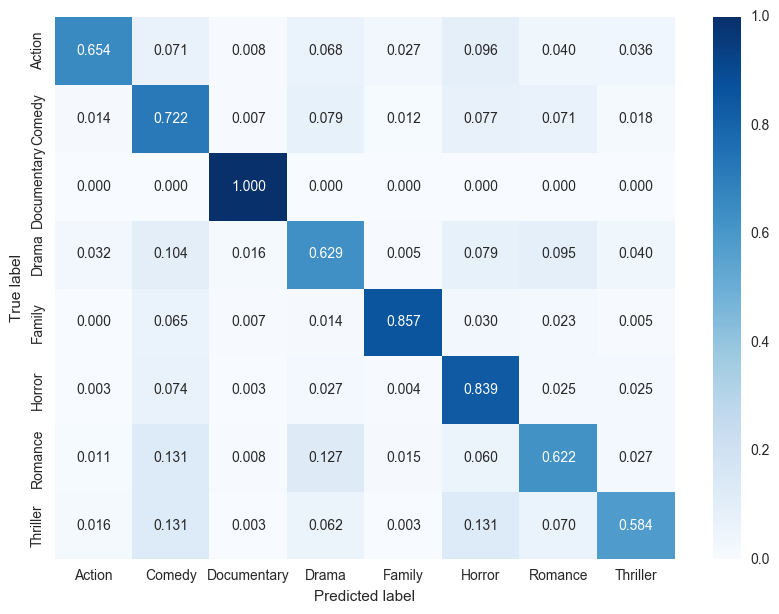

Test Accuracy: 0.3837
Test Precision - Weighted: 0.4071
Test Recall - Weighted: 0.3837
Test F1 - Weighted: 0.3854


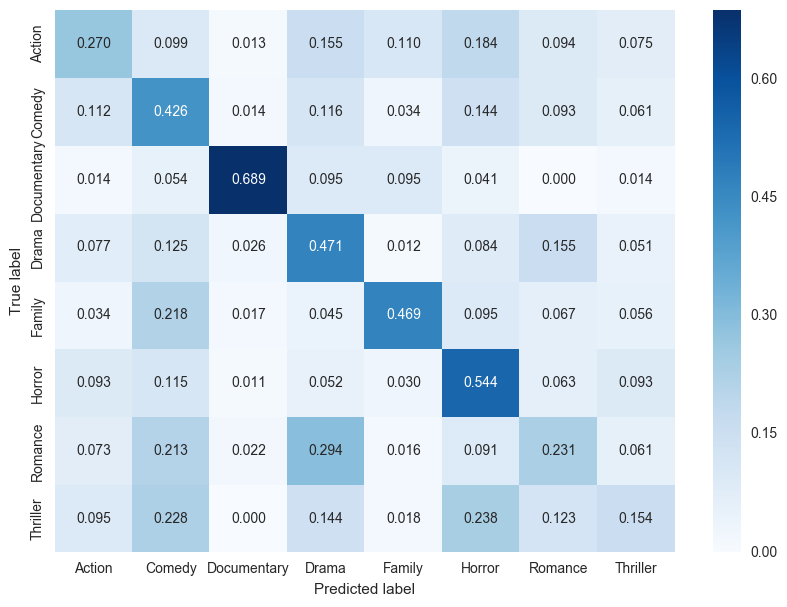

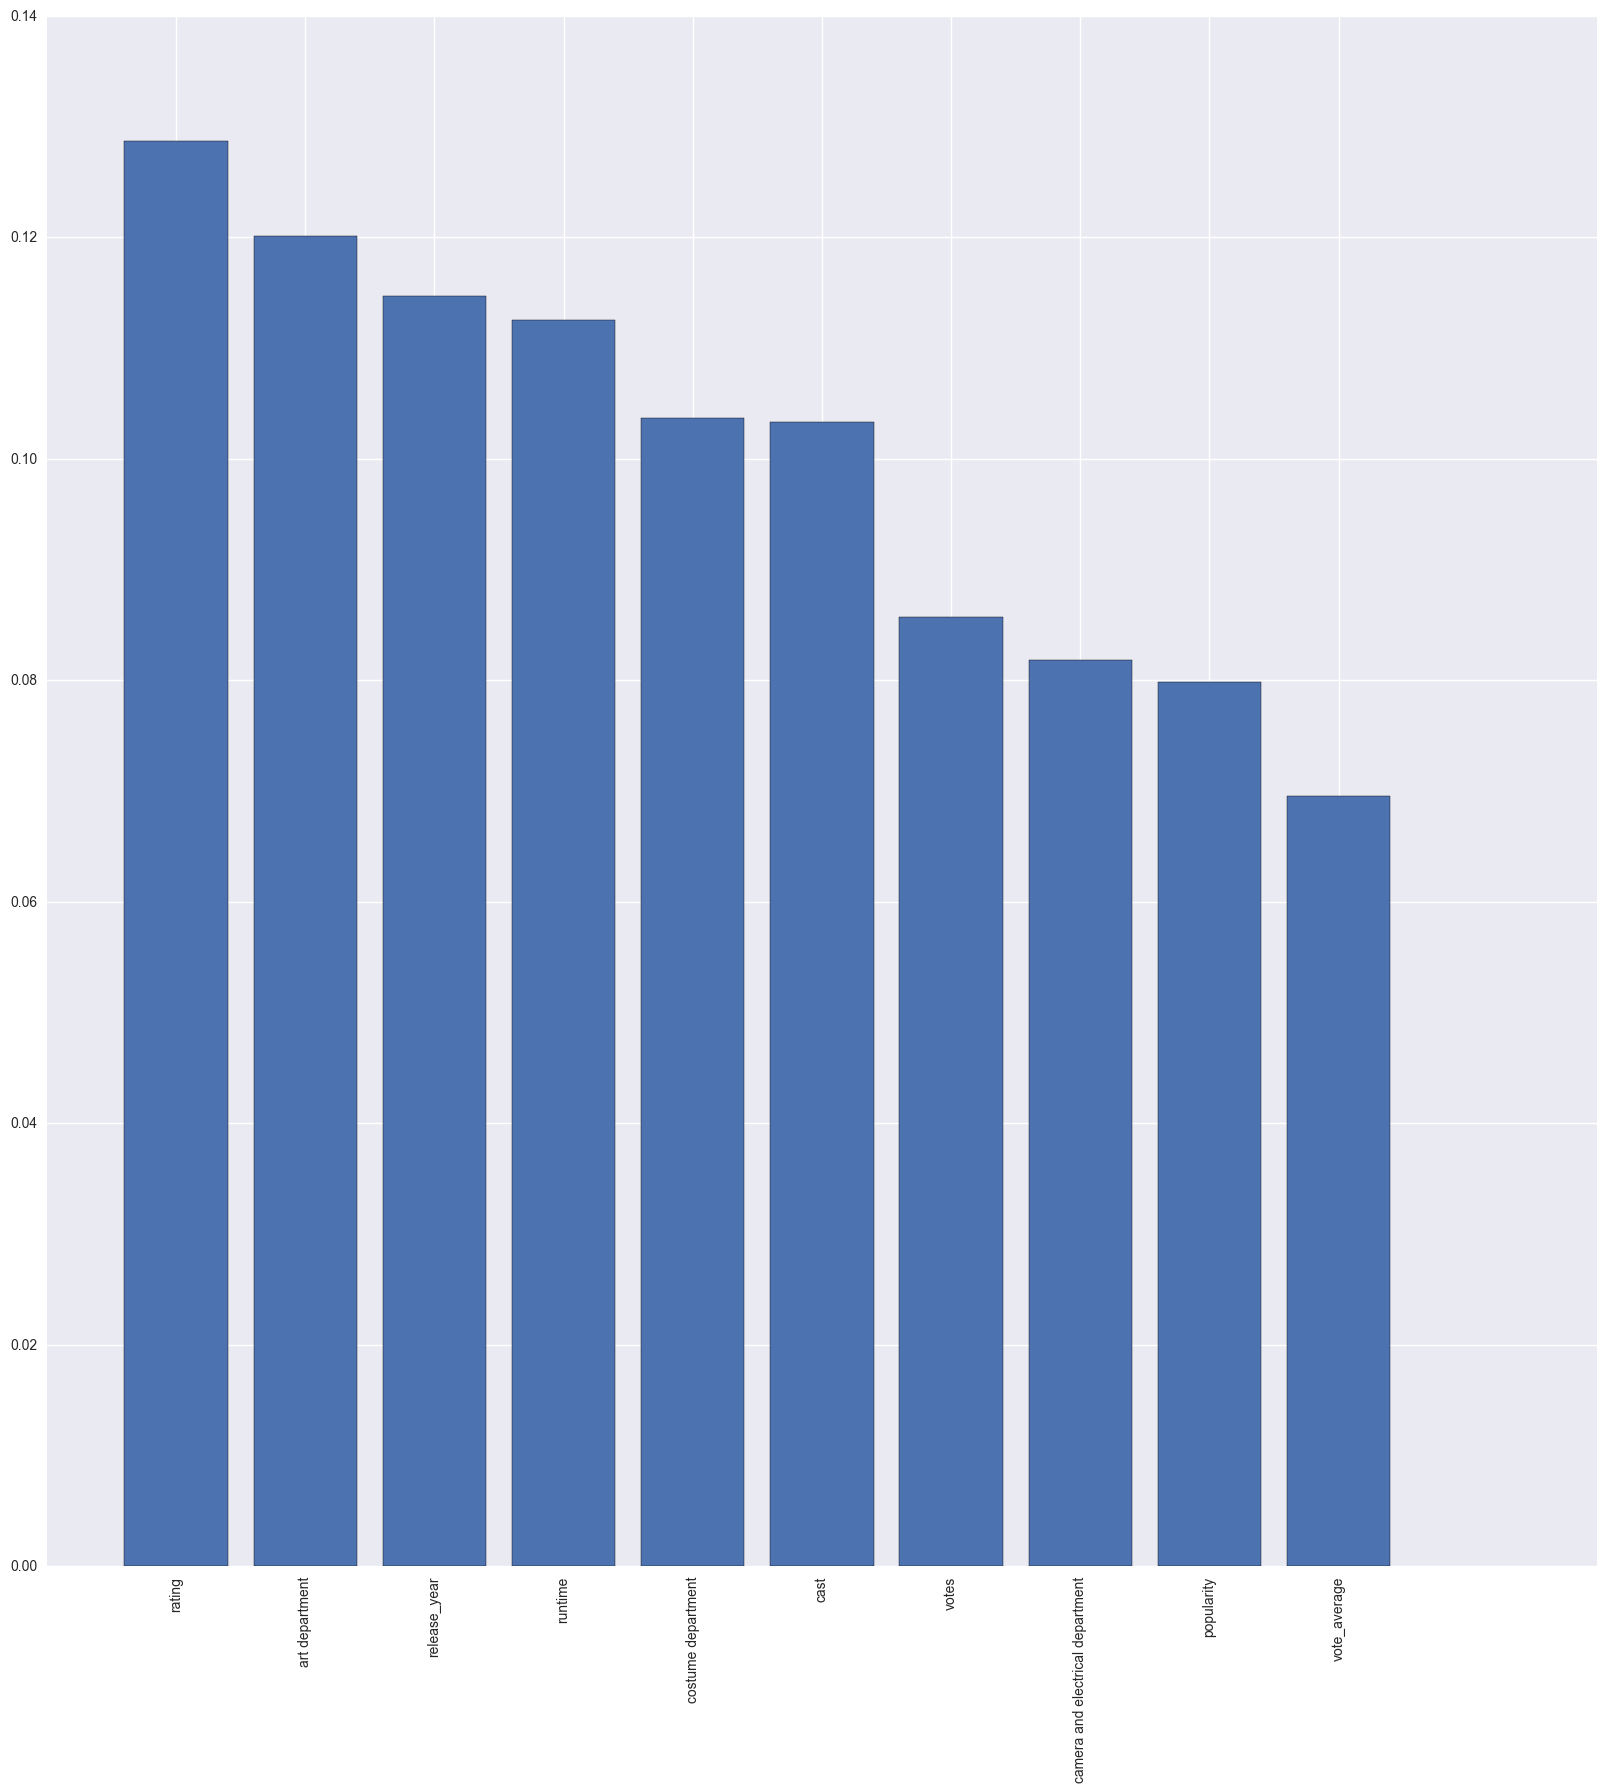

In [51]:
print(rf_model_cv_2.best_estimator_)
rf_model_chosen_2 = rf_model_cv_2.best_estimator_
model_evaluation(X_train_2, y_train, rf_model_chosen_2, 'Train')
model_evaluation(X_test_2, y_test, rf_model_chosen_2, 'Test')
get_feature_importance(rf_model_chosen_2, X_train_2)

# XGBoost

There is a lot of buzz that XGBoost is often a very strong classifier, and better than the Random Forest model. XGBoost is a GBM (generalized boosted model), and like RF, it uses decision trees. However, instead of completely randomizing the predictors in those trees, it learns from each previous tree and includes regularization.
Using the xgboost and sklearn packages, we tuned a XGBoost classifier using grid search with 5-fold cross-validation on the following parameters, as our research indicated these to be most crucial:
* `gamma` : Minimum loss reduction required to make a further partition on a leaf node of the tree.
* `min_child_weight` : Minimum sum of instance weight(hessian) needed in a child.
* `max_depth` : Maximum tree depth for base learners.
* `subsample` : Subsample ratio of the training instance.
* `colsample_bytree` : Subsample ratio of columns when constructing each tree.
* `reg_alpha` : L1 regularization term on weights
We also selected a relatively slow learning rate and large number of trees to be used.

Again, we chose the f1 score as the metric to maximize for our grid search

### Default Param Model

Train Accuracy: 0.5079
Train Precision - Weighted: 0.5046
Train Recall - Weighted: 0.5079
Train F1 - Weighted: 0.4812


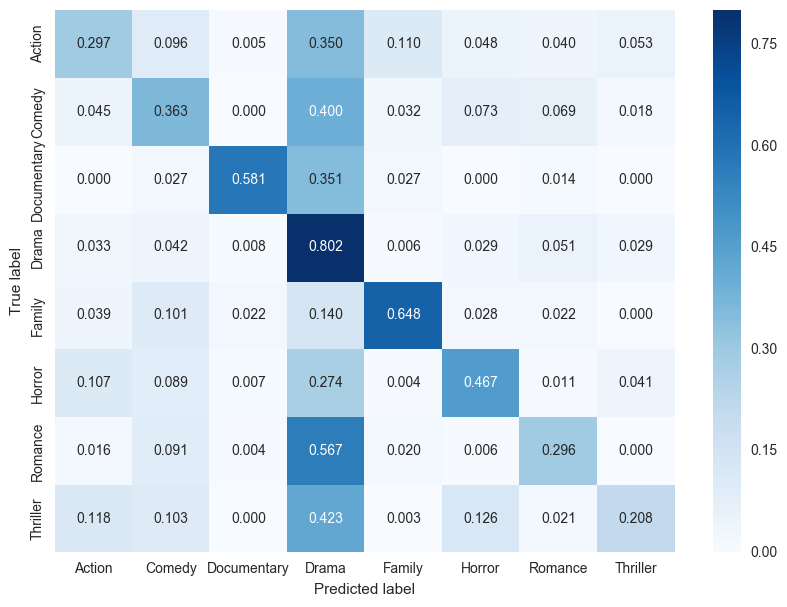

In [54]:
xgb_model_1 = XGBClassifier()
xgb_model_1.fit(X_train, y_train)
model_evaluation(X_test, y_test, xgb_model_1, 'Train')

### First Tune max_depth and min_child_weight

In [21]:
# parameter definitions
'''
max_depth : int
Maximum tree depth for base learners.
learning_rate : float
Boosting learning rate (xgb’s “eta”)
n_estimators : int
Number of boosted trees to fit.
silent : boolean
Whether to print messages while running boosting.
objective : string or callable
Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).
nthread : int
Number of parallel threads used to run xgboost.
gamma : float
Minimum loss reduction required to make a further partition on a leaf node of the tree.
min_child_weight : int
Minimum sum of instance weight(hessian) needed in a child.
max_delta_step : int
Maximum delta step we allow each tree’s weight estimation to be.
subsample : float
Subsample ratio of the training instance.
colsample_bytree : float
Subsample ratio of columns when constructing each tree.
colsample_bylevel : float
Subsample ratio of columns for each split, in each level.
reg_alpha : float (xgb’s alpha)
L1 regularization term on weights
reg_lambda : float (xgb’s lambda)
L2 regularization term on weights
scale_pos_weight : float
Balancing of positive and negative weights.
base_score:
The initial prediction score of all instances, global bias.
seed : int
Random number seed.
'''
xgb_model_2 = XGBClassifier()
XGB_PARAMETERS = {'max_depth': range(3,10,2), 'min_child_weight': range(0,6,2)}
xgb_model_2_cv = GridSearchCV(xgb_model_2, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose=100)
xgb_model_2_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=3, min_child_weight=0 .................................
[CV] ........ max_depth=3, min_child_weight=0, score=0.481317 -  11.8s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   11.8s
[CV] max_depth=3, min_child_weight=0 .................................
[CV] ........ max_depth=3, min_child_weight=0, score=0.467759 -  11.8s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   23.6s
[CV] max_depth=3, min_child_weight=0 .................................
[CV] ........ max_depth=3, min_child_weight=0, score=0.491269 -  11.9s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:   35.5s
[CV] max_depth=3, min_child_weight=0 .................................
[CV] ........ max_depth=3, min_child_weight=0, score=0.506199 -  11.7s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:   47.2s
[CV] max_depth=3, min_child_weight=0 .................................
[CV] ........ max_depth=3, min_child_weight=0, score

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [0, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=100)

In [22]:
xgb_model_2_cv.grid_scores_, xgb_model_2_cv.best_params_, xgb_model_2_cv.best_score_

([mean: 0.48534, std: 0.01282, params: {'max_depth': 3, 'min_child_weight': 0},
  mean: 0.48490, std: 0.01408, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.48451, std: 0.01339, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.49296, std: 0.01134, params: {'max_depth': 5, 'min_child_weight': 0},
  mean: 0.49503, std: 0.01313, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.49464, std: 0.01208, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.48742, std: 0.01166, params: {'max_depth': 7, 'min_child_weight': 0},
  mean: 0.49193, std: 0.01122, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: 0.49566, std: 0.00790, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.48215, std: 0.01578, params: {'max_depth': 9, 'min_child_weight': 0},
  mean: 0.49007, std: 0.01464, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: 0.49105, std: 0.01221, params: {'max_depth': 9, 'min_child_weight': 4}],
 {'max_depth': 7, 'min_child_weight': 4

### Second: Tune gamma

In [23]:
xgb_model_3 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_2_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'gamma': [i/10.0 for i in range(0,5)]})
print XGB_PARAMETERS
xgb_model_3_cv = GridSearchCV(xgb_model_3, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose=100)
xgb_model_3_cv.fit(X_train, y_train)
xgb_model_3_cv.grid_scores_, xgb_model_3_cv.best_params_, xgb_model_3_cv.best_score_

{'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'max_depth': [7], 'min_child_weight': [4]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] max_depth=7, gamma=0.0, min_child_weight=4 ......................
[CV]  max_depth=7, gamma=0.0, min_child_weight=4, score=0.499250 -  23.1s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   23.1s
[CV] max_depth=7, gamma=0.0, min_child_weight=4 ......................
[CV]  max_depth=7, gamma=0.0, min_child_weight=4, score=0.481459 -  23.2s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   46.3s
[CV] max_depth=7, gamma=0.0, min_child_weight=4 ......................
[CV]  max_depth=7, gamma=0.0, min_child_weight=4, score=0.502379 -  22.9s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:  1.2min
[CV] max_depth=7, gamma=0.0, min_child_weight=4 ......................
[CV]  max_depth=7, gamma=0.0, min_child_weight=4, score=0.502324 -  23.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:  1.5min
[CV] max_depth=7, gamma=0.0, min

([mean: 0.49566, std: 0.00790, params: {'max_depth': 7, 'gamma': 0.0, 'min_child_weight': 4},
  mean: 0.49458, std: 0.00989, params: {'max_depth': 7, 'gamma': 0.1, 'min_child_weight': 4},
  mean: 0.49418, std: 0.00941, params: {'max_depth': 7, 'gamma': 0.2, 'min_child_weight': 4},
  mean: 0.49318, std: 0.01085, params: {'max_depth': 7, 'gamma': 0.3, 'min_child_weight': 4},
  mean: 0.49682, std: 0.01106, params: {'max_depth': 7, 'gamma': 0.4, 'min_child_weight': 4}],
 {'gamma': 0.4, 'max_depth': 7, 'min_child_weight': 4},
 0.49681661986289832)

### Third: Tune subsample and colsample_bytree

In [24]:
xgb_model_4 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_3_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'subsample':[i/10.0 for i in range(6,10)],
                       'colsample_bytree':[i/10.0 for i in range(6,10)]})
xgb_model_4_cv = GridSearchCV(xgb_model_4, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose=100)
xgb_model_4_cv.fit(X_train, y_train)
xgb_model_4_cv.grid_scores_, xgb_model_4_cv.best_params_, xgb_model_4_cv.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.4, min_child_weight=4 
[CV]  subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.4, min_child_weight=4, score=0.496847 -  17.6s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   17.6s
[CV] subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.4, min_child_weight=4 
[CV]  subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.4, min_child_weight=4, score=0.483579 -  17.7s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   35.3s
[CV] subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.4, min_child_weight=4 
[CV]  subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.4, min_child_weight=4, score=0.513374 -  17.6s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:   52.9s
[CV] subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.4, min_child_weight=4 
[CV]  subsample=0.6, colsample_bytree=0.6, max_depth=7, gamma=0.4, min_child

([mean: 0.49919, std: 0.01037, params: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.4, 'min_child_weight': 4},
  mean: 0.50019, std: 0.01019, params: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.4, 'min_child_weight': 4},
  mean: 0.50001, std: 0.01132, params: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.4, 'min_child_weight': 4},
  mean: 0.50206, std: 0.01140, params: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.4, 'min_child_weight': 4},
  mean: 0.49889, std: 0.01263, params: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 0.4, 'min_child_weight': 4},
  mean: 0.50363, std: 0.01119, params: {'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 0.4, 'min_child_weight': 4},
  mean: 0.50117, std: 0.01217, params: {'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 0.4, 'min_child_weight': 4},
  mean: 0.50200, std: 0.00891, params: {'

### Fourth: Tune regularization params

In [25]:
xgb_model_5 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_4_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'reg_alpha':[1e-5, 1e-3, 0.1, 1, 10, 100]})
xgb_model_5_cv = GridSearchCV(xgb_model_5, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose=100)
xgb_model_5_cv.fit(X_train, y_train)
xgb_model_5_cv.grid_scores_, xgb_model_5_cv.best_params_, xgb_model_5_cv.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] reg_alpha=1e-05, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4 
[CV]  reg_alpha=1e-05, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4, score=0.506235 -  22.9s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   22.9s
[CV] reg_alpha=1e-05, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4 
[CV]  reg_alpha=1e-05, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4, score=0.482105 -  22.6s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   45.5s
[CV] reg_alpha=1e-05, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4 
[CV]  reg_alpha=1e-05, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4, score=0.514745 -  22.7s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:  1.1min
[CV] reg_alpha=1e-05, colsample_bytree=0.7, min_child_weight=

([mean: 0.50363, std: 0.01119, params: {'reg_alpha': 1e-05, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4},
  mean: 0.49981, std: 0.01061, params: {'reg_alpha': 0.001, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4},
  mean: 0.50180, std: 0.01019, params: {'reg_alpha': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4},
  mean: 0.50268, std: 0.01150, params: {'reg_alpha': 1, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4},
  mean: 0.49743, std: 0.01166, params: {'reg_alpha': 10, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4},
  mean: 0.30829, std: 0.00745, params: {'reg_alpha': 100, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4}],
 {'colsample_bytree': 0.7,
  'gamma': 0.4,
  'max_depth': 7,
  'min_

In [26]:
xgb_model_6 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_5_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'reg_alpha':[.01, .05, 0.1, .3, .5, .75]})
xgb_model_6_cv = GridSearchCV(xgb_model_6, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose = 100)
xgb_model_6_cv.fit(X_train, y_train)
xgb_model_6_cv.grid_scores_, xgb_model_6_cv.best_params_, xgb_model_6_cv.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] reg_alpha=0.01, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4 
[CV]  reg_alpha=0.01, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4, score=0.498612 -  23.1s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   23.1s
[CV] reg_alpha=0.01, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4 
[CV]  reg_alpha=0.01, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4, score=0.481263 -  23.5s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   46.6s
[CV] reg_alpha=0.01, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4 
[CV]  reg_alpha=0.01, colsample_bytree=0.7, min_child_weight=4, subsample=0.7, max_depth=7, gamma=0.4, score=0.502315 -  27.5s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:  1.2min
[CV] reg_alpha=0.01, colsample_bytree=0.7, min_child_weight=4, subs

([mean: 0.49707, std: 0.00823, params: {'reg_alpha': 0.01, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4},
  mean: 0.49922, std: 0.00926, params: {'reg_alpha': 0.05, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4},
  mean: 0.50180, std: 0.01019, params: {'reg_alpha': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4},
  mean: 0.50160, std: 0.01373, params: {'reg_alpha': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4},
  mean: 0.50294, std: 0.01217, params: {'reg_alpha': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4},
  mean: 0.50501, std: 0.01327, params: {'reg_alpha': 0.75, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'subsample': 0.7, 'max_depth': 7, 'gamma': 0.4}],
 {'colsample_bytree': 0.7,
  'gamma': 0.4,
  'max_depth': 7,
  'mi

### Fifth: Reduce Learning Rate, Add More Tree

In [28]:
xgb_model_final = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    colsample_bytree = 0.7,
    gamma = 0.4,
    max_depth = 7,
    min_child_weight = 0,
    reg_alpha =0.75,
    subsample = 0.7)
print "here"
xgb_model_final.fit(X_train, y_train, verbose = 100)

here


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=0, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0.75, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

Train Accuracy: 0.9999
Train Precision - Weighted: 0.9999
Train Recall - Weighted: 0.9999
Train F1 - Weighted: 0.9999


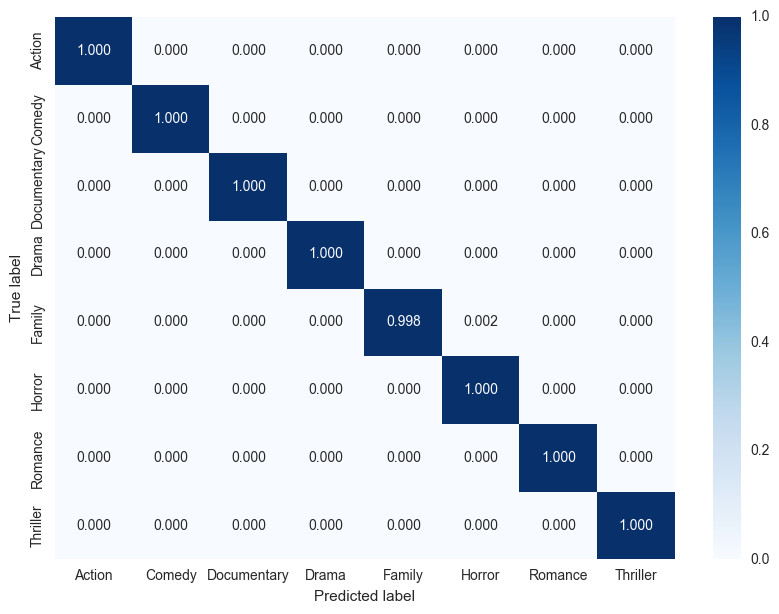

Test Accuracy: 0.5056
Test Precision - Weighted: 0.4928
Test Recall - Weighted: 0.5056
Test F1 - Weighted: 0.4909


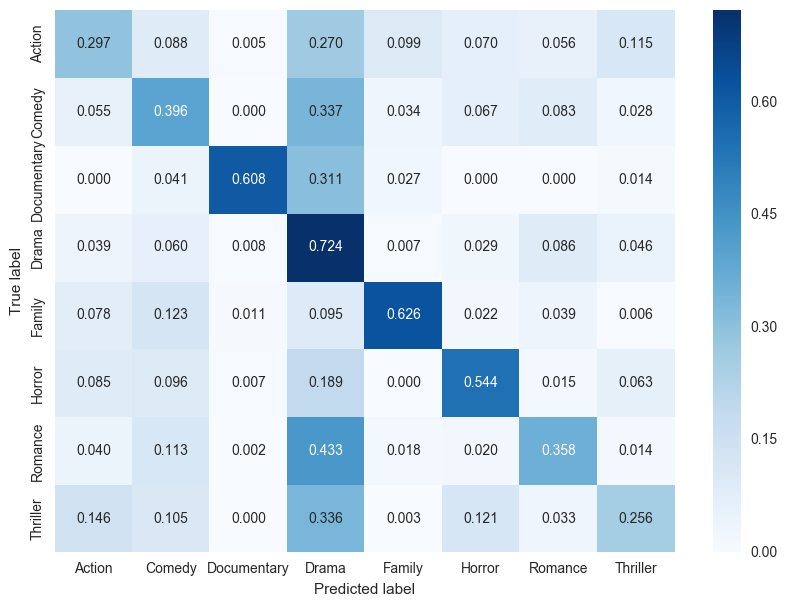

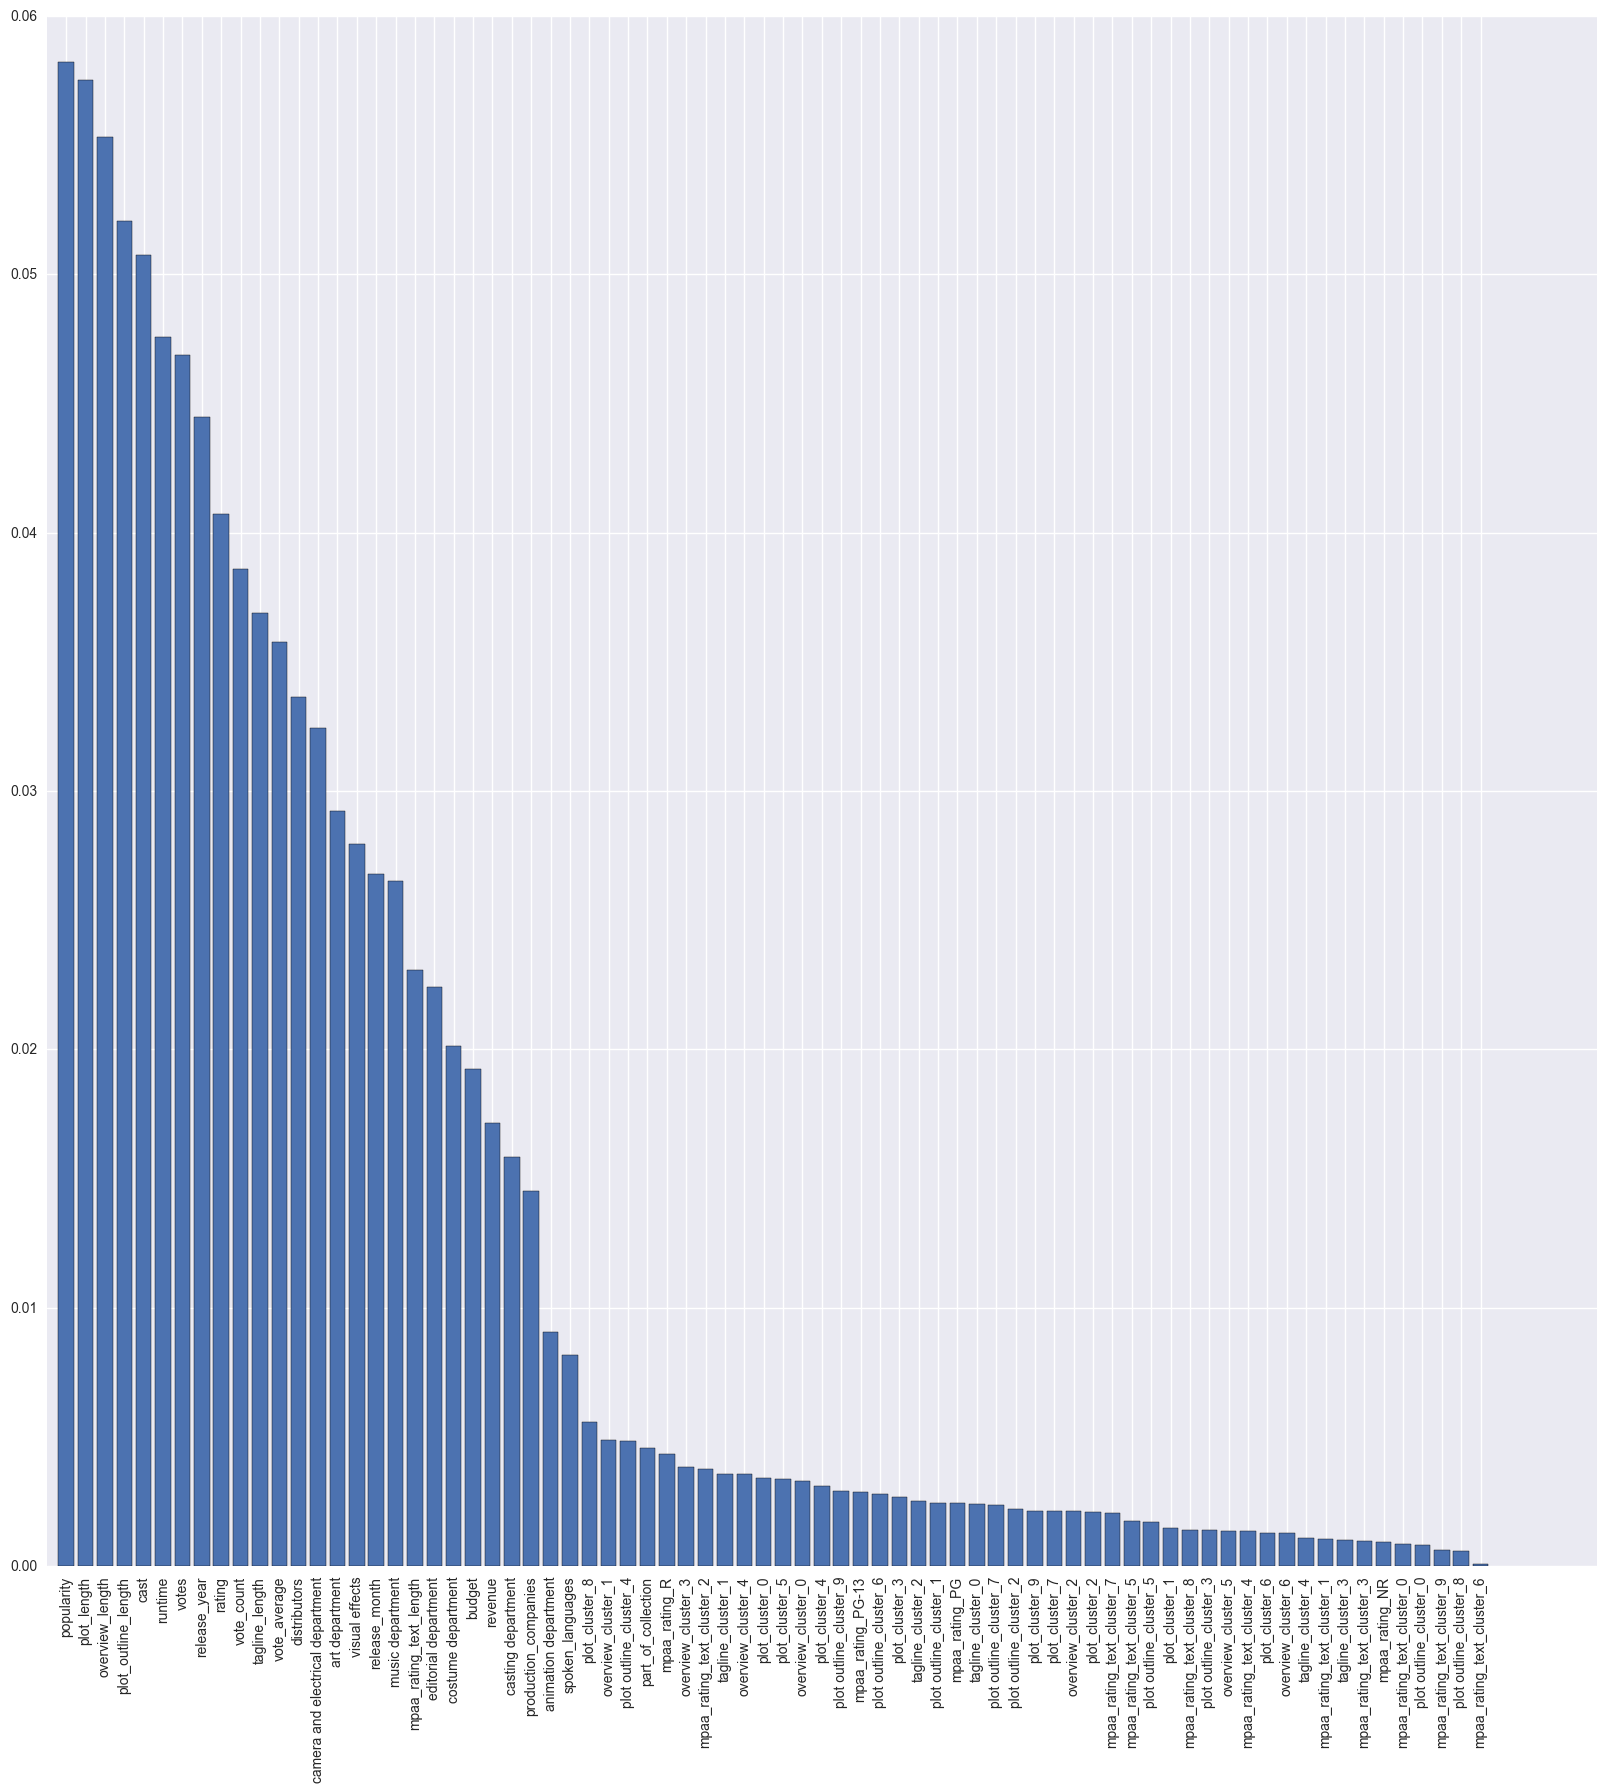

In [53]:
model_evaluation(X_train, y_train, xgb_model_final, 'Train')
model_evaluation(X_test, y_test, xgb_model_final, 'Test')
get_feature_importance(xgb_model_final, X_train)

The most impactful features were popularity, `overview_length`, `plot_length`, `plot_outline_length`, and `cast`. It is surprising that `overview_length`, `plot_length`, and `plot_outline_length` had such high feature importance.
Additionally, it's important to consider that our accuracy was achieved across 8 classes, and that these classes have overlap. For example, it's not surprising that it's hard to distinguish between Drama and Romance.

# Compare Models

While random forest grows trees independently of other trees, xgboost looks to minimize the residuals produced by the model by growing additional trees based on the residuals of the previous trees. This can lead xgboost to perform better than random forest if tuned correctly but also makes it more prone to overfit if the model fits the residuals too well. Tuning the XGBoost model takes longer as well since trees are not grown separately and there are more parameters to tune.

### RF Models

As discussed above, despite the high train set evaluation metrics, the random forest with all of the features still performs the best on the test set.

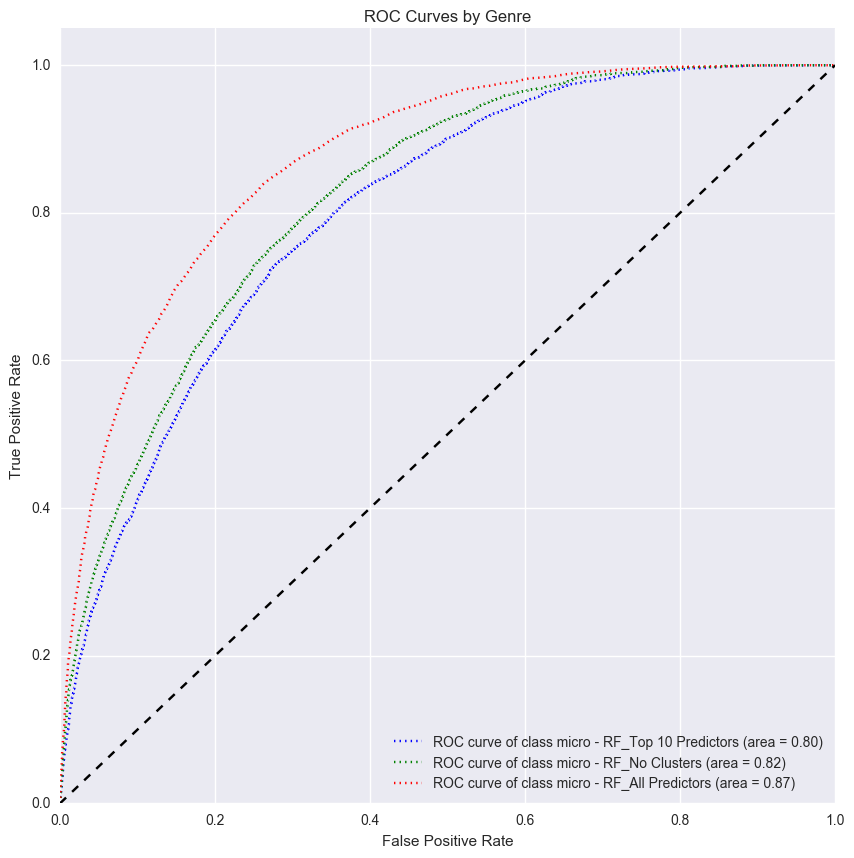

In [30]:
model_list_1 = [(rf_model_chosen, X_test), (rf_model_chosen_1, X_test_1), (rf_model_chosen_2, X_test_2)]
plot_roc(model_list_1, ['RF_All Predictors', 'RF_No Clusters', 'RF_Top 10 Predictors'], y_test)

### RF and XGB Model Comparison

The performance of both models is effectively equal in terms of AUC. In the confusion matrices, you can see that XGBoost does a better job of predicting non-drama classes, at the expense of worse accuracy on the largest class.

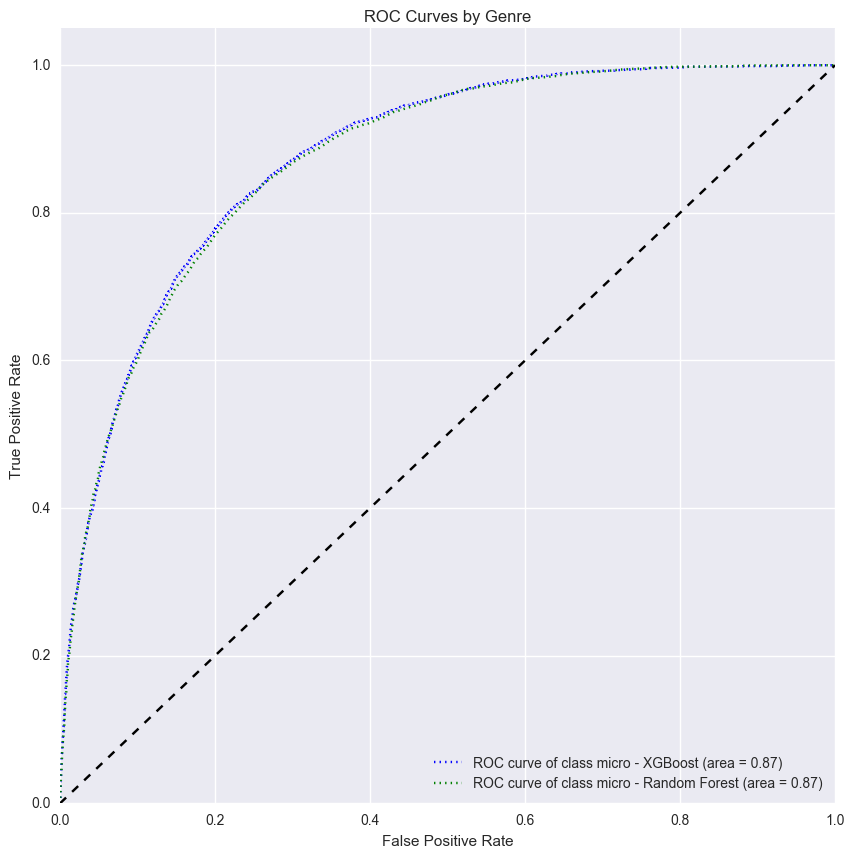

In [31]:
model_list_2 = [(rf_model_chosen, X_test), (xgb_model_final, X_test)]
plot_roc(model_list_2, ['Random Forest', 'XGBoost'], y_test)

Test Accuracy: 0.5056
Test Precision - Weighted: 0.4928
Test Recall - Weighted: 0.5056
Test F1 - Weighted: 0.4909


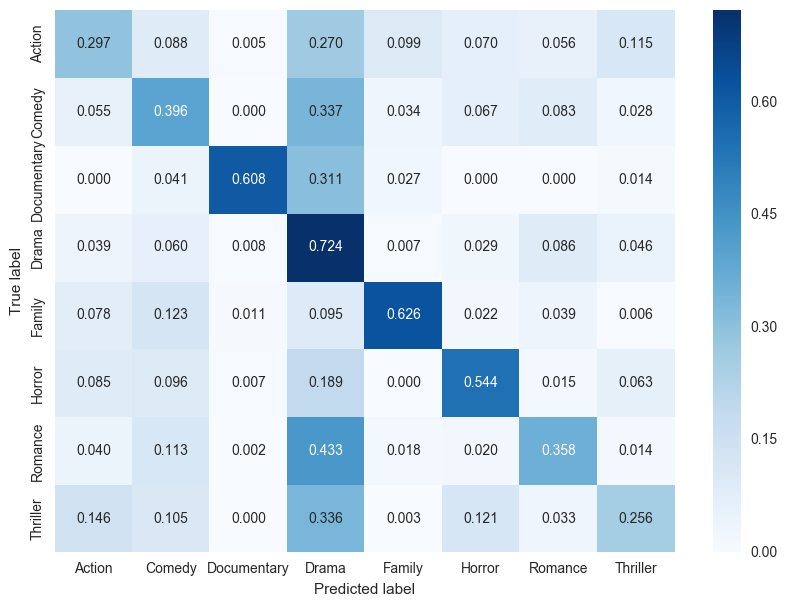

In [42]:
model_evaluation_2(X_test, y_test, xgb_model_final, 'Test')

Test Accuracy: 0.5104
Test Precision - Weighted: 0.5139
Test Recall - Weighted: 0.5104
Test F1 - Weighted: 0.4764


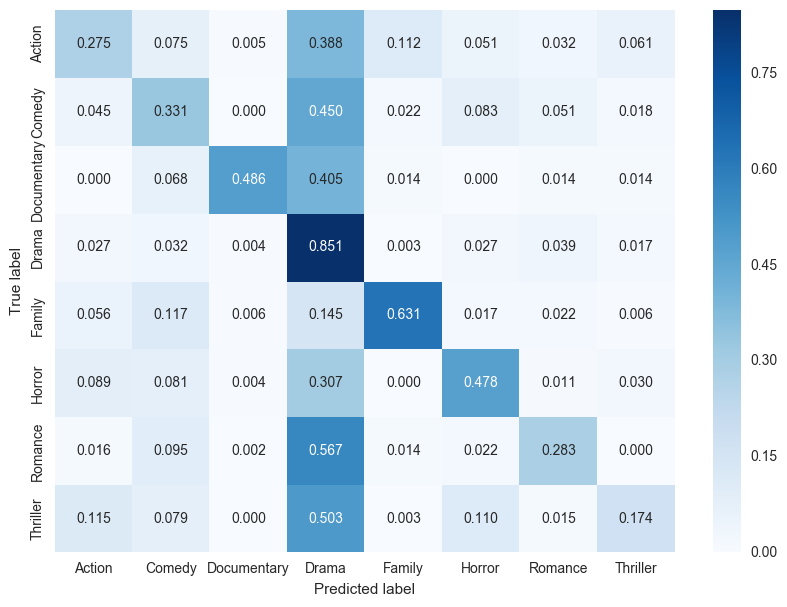

In [45]:
model_evaluation_2(X_test, y_test, rf_model_chosen, 'Test')

# Model Improvement

There are a few ways we could improve these models:
* `Tune on More Parameters`: We could look tune more parameters on the models, both by including completely new parameters (varying the criterion in the random forest model) or increasing the number of values for existing parameters (testing 500, 1000, and 2000 max_features for random forest)
* `Include More Features`: We did attempt some PCA on a subset of the movie posters but did not do it for the entire dataset. IMDb also offers more features for the movies so we could include those. We could also try more clustering techniques, including agglomerative ones, on the text variables and see if the results improve performance.
* `Change Genre Configuration`: Since we combined various genre classes together based on personal judgement, we might have combined some incorrectly making differences between the genres harder to distinguish than they are in reality.
* `Consider Outputing Probability Distributions`: Due to the overlap between our genre categories (as some are defined as intersections of others), it might be interesting to see what the model's probability distribution by category looks like. For example, is it confident that movies whose actual label contains 'Comedy' fall under some category containing 'Comedy'? Or is it also predicting that a movie whose actual label contains 'Comedy' is likely to fall into 'Documentary' too?

# PCA and SVM

As noted above, we began to explore the posters data by using PCA and multi-class prediction with SVM on a random subset of the movie posters (400 train and 400 test). The performance was poor - about 19% test accuracy with tuned linear and radial kernels - and the computation time was very high. We view this exploratory analysis as a useful benchmark or point of comparison for the deep learning models.

The Rmd code is available here: https://github.com/All-Star-Vipers/CS109B-Final-Project/blob/master/Milestone%203/PCA-SVM.Rmd

And the HTML output from the Rmd file is available at this link: https://all-star-vipers.github.io/CS109B-Final-Project/Milestone%203/PCA-SVM.html